In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../") 

import os
import yaml
import numpy as np
import textwrap
import json
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Optima"
plt.rcParams["font.weight"] = "light"

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import arviz as az

from epimodel import preprocess_data, run_model, EpidemiologicalParameters
from epimodel.plotting.intervention_plots import combine_npi_samples

In [2]:
#### Instructions: completely re-run for both DATA sets

#DATA = 'BraunerTE'
DATA = 'Sharma'



default_alpha = None
if DATA == "Sharma":
    data = preprocess_data('../../data/modelSharma_dataSharma.csv')
    data.featurize(drop_npi_filter=[
        {"query": "Childcare Closed", "type": "equals"},
        {"query": "All Face-to-Face Businesses Closed", "type": "equals"},
    ])
    data.mask_new_variant(new_variant_fraction_fname='../../data/nuts3_new_variant_fraction.csv')
    data.mask_from_date('2021-01-09') 

    default_names = data.CMs
else:
    data = preprocess_data('../../data/modelSharma_dataBraunerTE.csv', start_date="2020-01-22", end_date="2020-05-30", household_feature_processing="raw")
    data.featurize(all_binary=True)
    data.mask_from_date("2020-05-30") 

    default_names = data.CMs
print(default_names)

Processing data from 2020-08-01 00:00:00 to 2021-01-22 00:00:00
masking 0 + 0 small values (cummulative)
Note: under drop_outdoor gathering aggregation, the gatherings_aggregation_type is disregarded
['Some Face-to-Face Businesses Closed', 'Gastronomy Closed', 'Leisure Venues Closed', 'Retail Closed', 'Curfew', 'Primary Schools Closed', 'Secondary Schools Closed', 'Universities Away', 'Public Indoor Gathering Person Limit - 1', 'Public Indoor Gathering Person Limit - 2', 'Public Indoor Gathering Person Limit - 10', 'Public Indoor Gathering Person Limit - 30', 'Extra Public Indoor Household Limit', 'Private Indoor Gathering Person Limit - 1', 'Private Indoor Gathering Person Limit - 2', 'Private Indoor Gathering Person Limit - 10', 'Private Indoor Gathering Person Limit - 30', 'Extra Private Indoor Household Limit', 'Mandatory Mask Wearing >= 3']


In [3]:
colors = [*sns.color_palette("colorblind"), *sns.color_palette("dark")]

# Not really relevant here
cols = sns.color_palette('dark')

if DATA == "Sharma":
    corrected_names = [
        'Night clubs closed',
        'Gastronomy closed',
        'Leisure venues closed',
        'Retail and close-contact\nservices closed',
        'Night time curfew',
        'Primary schools closed',
        'Secondary schools closed',
        'Universities closed',
        'All public gatherings banned',
        'Public gatherings limited to 2 people', 
        'Public gatherings limited to ≤10 people',
        'Public gatherings limited to ≤30 people', 
        'Public gatherings limited to 2 households',
        'All household mixing in private banned',
        'Household mixing in private limited to 2 people', 
        'Household mixing in private limited to ≤10 people',
        'Household mixing in private limited to ≤30 people', 
        'Household mixing in private limited to 2 households',
        'Stricter mask-wearing\npolicy',
    ]

    grouped_npis = {
        'All non-essential\nbusinesses closed': {
            'npis': ['Retail Closed', 'Some Face-to-Face Businesses Closed', 
                    'Gastronomy Closed', 'Leisure Venues Closed'],
            'type': 'exclude',
            'color': cols[0],
            'main': True,
        },
        'Night clubs closed': {
            'npis': ['Some Face-to-Face Businesses Closed'],
            'type': "exclude",
            'color': cols[0],
            'main': False,
        },
        'Leisure and entertainment\nvenues closed': {
            'npis': ['Leisure Venues Closed'],
            'type': 'exclude',
            'color': cols[0],
            'main': False,
        },
        'Gastronomy closed': {
            'npis': ['Gastronomy Closed'],
            'type': 'exclude',
            'color': cols[0],
            'main': False,
        },
        'Retail and close-contact\nservices closed': {
            'npis': ['Retail Closed'],
            'type': 'exclude',
            'color': cols[0],
            'main': False,
        },
        'All gatherings banned': {
            'npis': ['Public Indoor Gathering Person Limit - 1',
                    'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    'Extra Public Indoor Household Limit',
                    'Private Indoor Gathering Person Limit - 1',
                    'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    'Extra Private Indoor Household Limit'
                    ],
            'type': 'exclude',
            'color': cols[3],
            'main': True
        },
        'All gatherings limited to 2 people': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    'Extra Public Indoor Household Limit',
                    #'Private Indoor Gathering Person Limit - 1',
                    'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    'Extra Private Indoor Household Limit'
                    ],
            "type": "exclude",
            'color': cols[3],
            'main': False
        },
        'All gatherings limited to ≤10 people\nfrom 2 households': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    #'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    'Extra Public Indoor Household Limit',
                    #'Private Indoor Gathering Person Limit - 1',
                    #'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    'Extra Private Indoor Household Limit'
                    ],
            'type': 'exclude',
            'color': cols[3],
            'main': False
        },
        'All gatherings limited to ≤10 people': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    #'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    #'Extra Public Indoor Household Limit',
                    #'Private Indoor Gathering Person Limit - 1',
                    #'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    #'Extra Private Indoor Household Limit'
                    ],
            'type': 'exclude',
            'color': cols[3],
            'main': False
        },
        'All gatherings limited to ≤30 people': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    #'Public Indoor Gathering Person Limit - 2',
                    #'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    #'Extra Public Indoor Household Limit',
                    #'Private Indoor Gathering Person Limit - 1',
                    #'Private Indoor Gathering Person Limit - 2',
                    #'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    #'Extra Private Indoor Household Limit'
                    ],
            'type': 'exclude',
            'color': cols[3],
            'main': False
        },
        'All educational\ninstitutions closed': {
            'npis': ['Primary Schools Closed', 'Secondary Schools Closed', 'Universities Away'],
            'type': 'exclude',
            'color': cols[2],
            'main': True
        },
        'Night time curfew': {
            'npis': ['Curfew'],
            'type': 'exclude',
            'color': cols[1],
            'main': True
        },
        'Stricter mask-wearing\npolicy': {
            'npis': ['Mandatory Mask Wearing >= 3'],
            'type': 'exclude',
            'color': cols[1],
            'main': True
        },
        'All public gatherings banned': {
            'npis': ['Public Indoor Gathering Person Limit - 1',
                    'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    'Extra Public Indoor Household Limit',
                    ],
            'type': 'exclude',
            'color': cols[4],
        },
        'Public gatherings limited to 2 people': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    'Extra Public Indoor Household Limit',
                    ],
            "type": "exclude",
            'color': cols[4],
        },
        'Public gatherings limited to ≤10 people\nfrom 2 households': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    #'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    'Extra Public Indoor Household Limit',
                    ],
            'type': 'exclude',
            'color': cols[4],
        },
        'Public gatherings limited to ≤10 people': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    #'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    ],
            'type': 'exclude',
            'color': cols[4],
        },
        'Public gatherings limited to ≤30 people': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    #'Public Indoor Gathering Person Limit - 2',
                    #'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    ],
            'type': 'exclude',
            'color': cols[4],
        },
        'All household mixing in private banned': {
            'npis': ['Private Indoor Gathering Person Limit - 1',
                    'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    'Extra Private Indoor Household Limit'
                    ],
            'type': 'exclude',
            'color': cols[5],
        },
        'Household mixing in private\nlimited to 2 people': {
            'npis': [#'Private Indoor Gathering Person Limit - 1',
                    'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    'Extra Private Indoor Household Limit'
                    ],
            "type": "exclude",
            'color': cols[5],
        },
        'Household mixing in private\nlimited to ≤10 people from 2 households': {
            'npis': [#'Private Indoor Gathering Person Limit - 1',
                    #'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    'Extra Private Indoor Household Limit'
                    ],
            'type': 'exclude',
            'color': cols[5],
        },
        'Household mixing in private\nlimited to ≤10 people': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    #'Extra Public Indoor Household Limit',
                    #'Private Indoor Gathering Person Limit - 1',
                    #'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    #'Extra Private Indoor Household Limit'
                    ],
            'type': 'exclude',
            'color': cols[5],
        },
        'Household mixing in private\nlimited to ≤30 people': {
            'npis': [#'Public Indoor Gathering Person Limit - 1',
                    #'Public Indoor Gathering Person Limit - 2',
                    #'Public Indoor Gathering Person Limit - 10',
                    #'Extra Public Indoor Household Limit',
                    #'Private Indoor Gathering Person Limit - 1',
                    #'Private Indoor Gathering Person Limit - 2',
                    #'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    #'Extra Private Indoor Household Limit'
                    ],
            'type': 'exclude',
            'color': cols[5],
        },
        'Combined effect of all NPIs': {
            'npis': ['Some Face-to-Face Businesses Closed',
                    'Gastronomy Closed',
                    'Leisure Venues Closed',
                    'Retail Closed',
                    'Curfew',
                    'Primary Schools Closed',
                    'Secondary Schools Closed',
                    'Universities Away',
                    'Public Indoor Gathering Person Limit - 1',
                    'Public Indoor Gathering Person Limit - 2',
                    'Public Indoor Gathering Person Limit - 10',
                    'Public Indoor Gathering Person Limit - 30',
                    'Extra Public Indoor Household Limit',
                    'Private Indoor Gathering Person Limit - 1',
                    'Private Indoor Gathering Person Limit - 2',
                    'Private Indoor Gathering Person Limit - 10',
                    'Private Indoor Gathering Person Limit - 30',
                    'Extra Private Indoor Household Limit',
                    'Mandatory Mask Wearing >= 3'],
            "type": 'include'
        }
    }

else:
    corrected_names = ['Gatherings <1000', 'Gatherings <100', 'Gatherings <10',
        'Some Businesses Suspended', 'Most Businesses Suspended', 'School Closure', 'University Closure', 'Stay Home Order']
    grouped_npis = {
        'Gatherings limited to\n1000 people or less': {
            'npis': ['Gatherings <1000'],
            'type': 'exclude', 'color': cols[0],
        },
        'Gatherings limited to\n100 people or less': {
            'npis': ['Gatherings <1000', 'Gatherings <100'],
            'type': 'exclude', 'color': cols[0],
        },
        'Gatherings limited to\n10 people or less': {
            'npis': ['Gatherings <1000', 'Gatherings <100', 'Gatherings <10'],
            'type': 'exclude', 'color': cols[0],
        },
        'Some businesses closed': {
            'npis': ['Some Businesses Suspended'],
            'type': 'exclude', 'color': cols[1],
        },
        'Most nonessential\nbusinesses closed': {
            'npis': ['Some Businesses Suspended', 'Most Businesses Suspended'],
            'type': 'exclude', 'color': cols[1],
        },
        'Schools and universities\nclosed': {
            'npis': ['School Closure', 'University Closure'],
            'type': 'exclude', 'color': cols[2],
        },
        'Additional benefit of\nstay-at-home order': {
            'npis': ['Stay Home Order'],
            'type': 'exclude', 'color': cols[0],
        },
        'Combined effect of all NPIs': {
            'npis': ['Gatherings <1000', 'Gatherings <100', 'Gatherings <10',
                     'Some Businesses Suspended', 'Most Businesses Suspended',
                     'School Closure', 'University Closure', 'Stay Home Order'],
            "type": 'include',
            "weight": 'bold',
        }
    }


In [4]:
def intervention_prior_labeler(d): 
    if float(d['exp_config']['intervention_prior']['scale']) == 20.0:
        return  "AsymmetricLaplace(0, 0.5, 20)"
    elif d['exp_config']['intervention_prior']['type'] == "normal":
        return f"Normal(0, {d['exp_config']['intervention_prior']['scale']}$^2$)"
    elif float(d['exp_config']['intervention_prior']['scale']) == 0.15:
        return "HalfNormal(0, 0.15$^2$)"

def get_all_experiments(path):
    experiments = []
    for subdir, dirs, files in os.walk(f'{path}'):
        for filename in files:
#             if filename.endswith('.yaml'):
#                 filepath = subdir + os.sep + filename
#                 print(filepath)
#                 with open(filepath) as f:
#                     try:
#                         data = yaml.safe_load(f)
#                         experiments.append(data)
#                     except:
#                         print('failed to load f')
            if filename.endswith('.json'):
                filepath = subdir + os.sep + filename
                print(filepath)
                with open(filepath) as f:
                    try:
                        data = json.load(f)
                        data["MODEL"] = re.search('model(.*)_', data['model_config_name']).groups()[0]
                        data["DATA"] = re.search('data(.*)', data['model_config_name']).groups()[0]
                        data["FILENAME"] = filepath
                        #print(f"Loaded {filename}")
                        experiments.append(data)
                    except:
                        print(f'failed to load {filename}')
    return experiments

def filter_by_exp_tag(experiments, exp_tag, exp_info):
    filtered = []
    for experiment in experiments:
        if experiment['exp_tag'] == exp_tag:
            filtered.append(experiment)
        elif "exp_matcher" in exp_info and exp_info["exp_matcher"](experiment):
            filtered.append(experiment)

    return filtered

class experiment_type():
    def __init__(self, experiments, exp_info, tag):
        self.exp_info = exp_info
        self.experiments = experiments
        self.exp_info["tag"] = tag
        
        if "alpha_i" in list(self.experiments[0].keys()):
            self.experiments.sort(key=lambda x: np.median(np.array(x['alpha_i'])[:, 0]))
        if "sort_key" in exp_info:
            self.experiments.sort(key=exp_info["sort_key"])

def get_unique_exp_tags(experiments):
    return list(np.unique([exp['exp_tag'] for exp in experiments]))

def make_all_experiment_classes(all_experiments, all_exp_info):
    classes = []
    for tag, info in all_exp_info.items():
        filtered_exps = filter_by_exp_tag(all_experiments, tag, info)
        if filtered_exps:
            exp_info = all_exp_info[tag]
            classes.append(experiment_type(filtered_exps, exp_info, tag))
        
    return classes

In [5]:
def add_trace_to_plot(samples, y_off, col, label, alpha, width, npi_comb_dict, cm_names, size=6, extra={}, npi_priority={}):
    comb_effects, new_names = combine_npi_samples(npi_comb_dict, samples, cm_names)    
    comb_effects = 100*(1-np.exp(-comb_effects))
    npi_order = list(npi_comb_dict.keys())
    nF = len(npi_order)

    for exn, exvals in extra.items():
        comb_effects = np.concatenate([comb_effects, np.reshape(exvals, (-1, 1))], axis=1)
        new_names.append(exn)
        npi_order.append(exn)
    npi_order.sort(key=lambda n: npi_priority.get(n, 0))

    y_vals = -np.array([npi_order.index(name) for name in new_names])
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)

    li, lq, m, uq, ui = np.percentile(comb_effects, [2.5, 25, 50, 75, 97.5], axis=0)
    plt.scatter(m, y_vals+y_off, marker="o", color=col, s=size, alpha=alpha, facecolor='white', zorder=3, linewidth=width/2)
    for cm in range(len(new_names)):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width, zorder=2)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width, zorder=2)


def setup_plot(experiment_class, npi_comb_dict, y_ticks = True, xlabel=True, x_lims=(-25, 50), newfig=True, bold_npis=(), npi_priority={}, fontsize=6):
    if newfig:
        plt.figure(figsize=(4, 6), dpi=400)
        
    ax = plt.gca()
    x_min, x_max = x_lims
    
    npi_order = list(npi_comb_dict.keys())
    npi_order.sort(key=lambda n: npi_priority.get(n, 0))
    plt.plot([0, 0], [1, -(len(npi_order)+2)], "--k", linewidth=0.5)

    xrange = np.array([x_min, x_max])
    
    for height in range(0, len(npi_order)+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.25, linewidth=0)
    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    
    if y_ticks:
        _, yts = plt.yticks(-np.arange(len(npi_order)), npi_order, fontsize=fontsize)
        for n in bold_npis:
            if n in npi_order:
                yts[npi_order.index(n)].set_fontweight("bold")
    else:
        plt.yticks([])
   
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(len(npi_order) - 0.25), 0.75])
    
    plt.plot([-100, 100], [-len(npi_order)+11.5, -len(npi_order)+11.5], 'k')

    if xlabel:
        plt.xlabel("Reduction in R", fontsize=8)

def plot_experiment_class(experiment_class, npi_comb_dict, x_lims=None, default_res=None, default_names=None,
        width=1, newfig=True, npi_fontsize=6,
        prefix="", legend=True, npi_priority={}):
    default_label = experiment_class.exp_info["default_label"]
    labeler = experiment_class.exp_info["labeler"]
    title = experiment_class.exp_info["title"]
    if callable(title):
        title = title(experiment_class.experiments[0])
    add = experiment_class.exp_info.get("add", ())

    extra_effects = []
    for e in experiment_class.experiments:
        extra_effects.append({})
        for an in add:
            if an[0] == "Seasonality peak-to-through":
                b1 = np.array(e["seasonality_beta1"])
                extra_effects[-1]["Seasonality peak-to-through\nR reduction"] = 100 * (1-(1-b1)/(1+b1))
            if an[0] == "Seasonality amplitude":
                extra_effects[-1]["Seasonality amplitude γ (in percent)\n(i.e. mid-to-trough R reduction)"] = 100 * np.array(e["seasonality_beta1"])
            if an[0] == "seasonality_df":
                df = an[1]
                extra_effects[-1]["Seasonality peak-to-through\n(Jan 1 to July 1) reduction"] = df["top-to-trough"].values

    #print(extra_effects)
    bold_npis = ["Combined effect of all NPIs"]
    npi_comb_dict_ext = dict(npi_comb_dict)
    for en in extra_effects[-1].keys():
        npi_comb_dict_ext[en] = None
        bold_npis.append(en)

    setup_plot(experiment_class, npi_comb_dict_ext, x_lims=x_lims, newfig=newfig, bold_npis=bold_npis,
        npi_priority=npi_priority, fontsize=npi_fontsize)
    y_off = -np.linspace(-0.3, 0.3, len(experiment_class.experiments)+1)
    if len(experiment_class.experiments) == 1:
        y_off = [0.0]
    for i, trace in enumerate(experiment_class.experiments):
        add_trace_to_plot(np.array(trace['alpha_i']), y_off[i], colors[i], labeler(trace), alpha=1, size=6 if len(y_off) > 1 else 14,
                            width=width, npi_comb_dict=npi_comb_dict, cm_names=trace['cm_names'], extra=extra_effects[i], npi_priority=npi_priority)

    if default_res is not None:
        add_trace_to_plot(default_res, y_off[-1], "k", default_label, alpha=1, 
                            width=width, npi_comb_dict=npi_comb_dict, cm_names=default_names, npi_priority=npi_priority)

    if legend:
        plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(0.99, 0.99), fontsize=6)
    plt.title(title, fontsize=8)
    plt.savefig(f'figures/appendix/sensitivity-fi/Fig_{prefix}{experiment_class.exp_info["tag"]}.pdf', bbox_inches='tight')

In [6]:
def load_jsons(paths, vars=("seasonality_beta1", "seasonality_max_R_day")):
    traces = []
    df = pd.DataFrame()
    for fn in paths:
        with open('../../'+fn) as f:
            d = json.load(f)
            d["MODEL"] = re.search('model(.*)_', d['model_config_name']).groups()[0]
            d["DATA"] = re.search('data(.*)', d['model_config_name']).groups()[0]
            d["LABEL"] = f"Seasonal {d['MODEL']} et al." #\n{d['DATA']} data" # NB: Change for 2x2 plots
            if d['DATA'] == "BraunerTE":
                d["LABEL"] += "\n(temperate Europe)"
            print(f"Loaded {d['MODEL']} model, {d['DATA']} data. Rhat: {d['rhat']}")
            traces.append(d)

            cols = {v: np.array(d[v]) for v in vars}
            cols["label"] = d["LABEL"]
            df = df.append(pd.DataFrame(cols), ignore_index=True)

    cols = {v: np.array(df[v].values) for v in vars}
    cols["label"] = "Combined"
    df = df.append(pd.DataFrame(cols), ignore_index=True)
    return traces, df

beta1_SRC=[
    "sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality/20220616-232520-31123_summary.json",
    #"sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_fourier/20220616-232550-31300_summary.json",
    ]

traces, df1 = load_jsons(beta1_SRC)
df1["top-to-trough"] = 100*(1-(1-df1["seasonality_beta1"]) / (1+df1["seasonality_beta1"]))
df1["gamma_percent"] = 100*df1["seasonality_beta1"]
df1["Seasonality peak"] = "January 1"
df1 = df1[df1.label=="Combined"].sample(5000)
print(df1.groupby('Seasonality peak').median()["top-to-trough"])

Loaded Sharma model, Sharma data. Rhat: {'med': 0.9999834895133972, 'upper': 1.0011179447174072, 'lower': 0.9996334910392761, 'min': 1.0044909815904361, 'max': 0.999599919967984}
Seasonality peak
January 1    42.790202
Name: top-to-trough, dtype: float64


In [9]:
per_model_exp_info = {
    "seasonality_fourier": {
        "title": lambda d: f"Sensitivity to the choice of the model of seasonal forcing",
        "labeler": lambda d: f'Fourier degree {d["model_kwargs"]["fourier_degree"]}' if "fourier_degree" in d["model_kwargs"] else
            ("Parameter interactions" if "interactions" in d["model_kwargs"] else "Default seasonality"),
        "default_label": f"No seasonality",
        "sort_key": lambda d: 9 if "interactions" in d["model_kwargs"] else int(d["model_kwargs"].get("fourier_degree", "0")),
        "add": [["Seasonality amplitude"], ["Seasonality peak-to-through"]],
        "exp_matcher": lambda d: d['exp_tag'] == "seasonality" or d['exp_tag'] == "seasonality_fourier",
    },
    "seasonality_interactions": {
        "title": lambda d: f"Sensitivity to parameter interactions",
        "labeler": lambda d: f'Fourier degree {d["model_kwargs"]["fourier_degree"]}' if "fourier_degree" in d["model_kwargs"] else
            ("Parameter interactions" if "interactions" in d["model_kwargs"] else "Default seasonality"),
        "default_label": f"No seasonality",
        "sort_key": lambda d: 9 if "interactions" in d["model_kwargs"] else int(d["model_kwargs"].get("fourier_degree", "0")),
        "add": [["Seasonality amplitude"], ["Seasonality peak-to-through"]],
        "exp_matcher": lambda d: d['exp_tag'] == "seasonality" or d['exp_tag'] == "seasonality_interactions",
    },
}


def NPI_effects_labeler(d):
    w = ""
    if d['DATA'] in ("Brauner", "BraunerW"):
        w = " (all)"
    if d['DATA'] == "BraunerTE":
        w = " (TE)"
    return f'{d["MODEL"]} {"seasonal" if "seasonality_beta1" in d else "original"}{w}'

cross_model_exp_info = dict()


../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality/20220616-232520-31123_summary.json
../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_fourier/20220616-232550-31300_summary.json
../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_fourier/20220619-113807-65280_summary.json
../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_fourier/20220616-232558-31424_summary.json
../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_fourier_S/20220616-232806-31919_summary.json
../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_interactions_S/20220617-110307-56905_summary.json
../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_interactions_S/20220616-232903-32053_summary.json
../../sensitivity_analysis/default_cmodelSharma_dataSharma/seasonality_interactions/20220617-101845-54280_summary.json
Filtered down to: 8 for data Sharma
Filtered down to: 0 for model Brauner
C

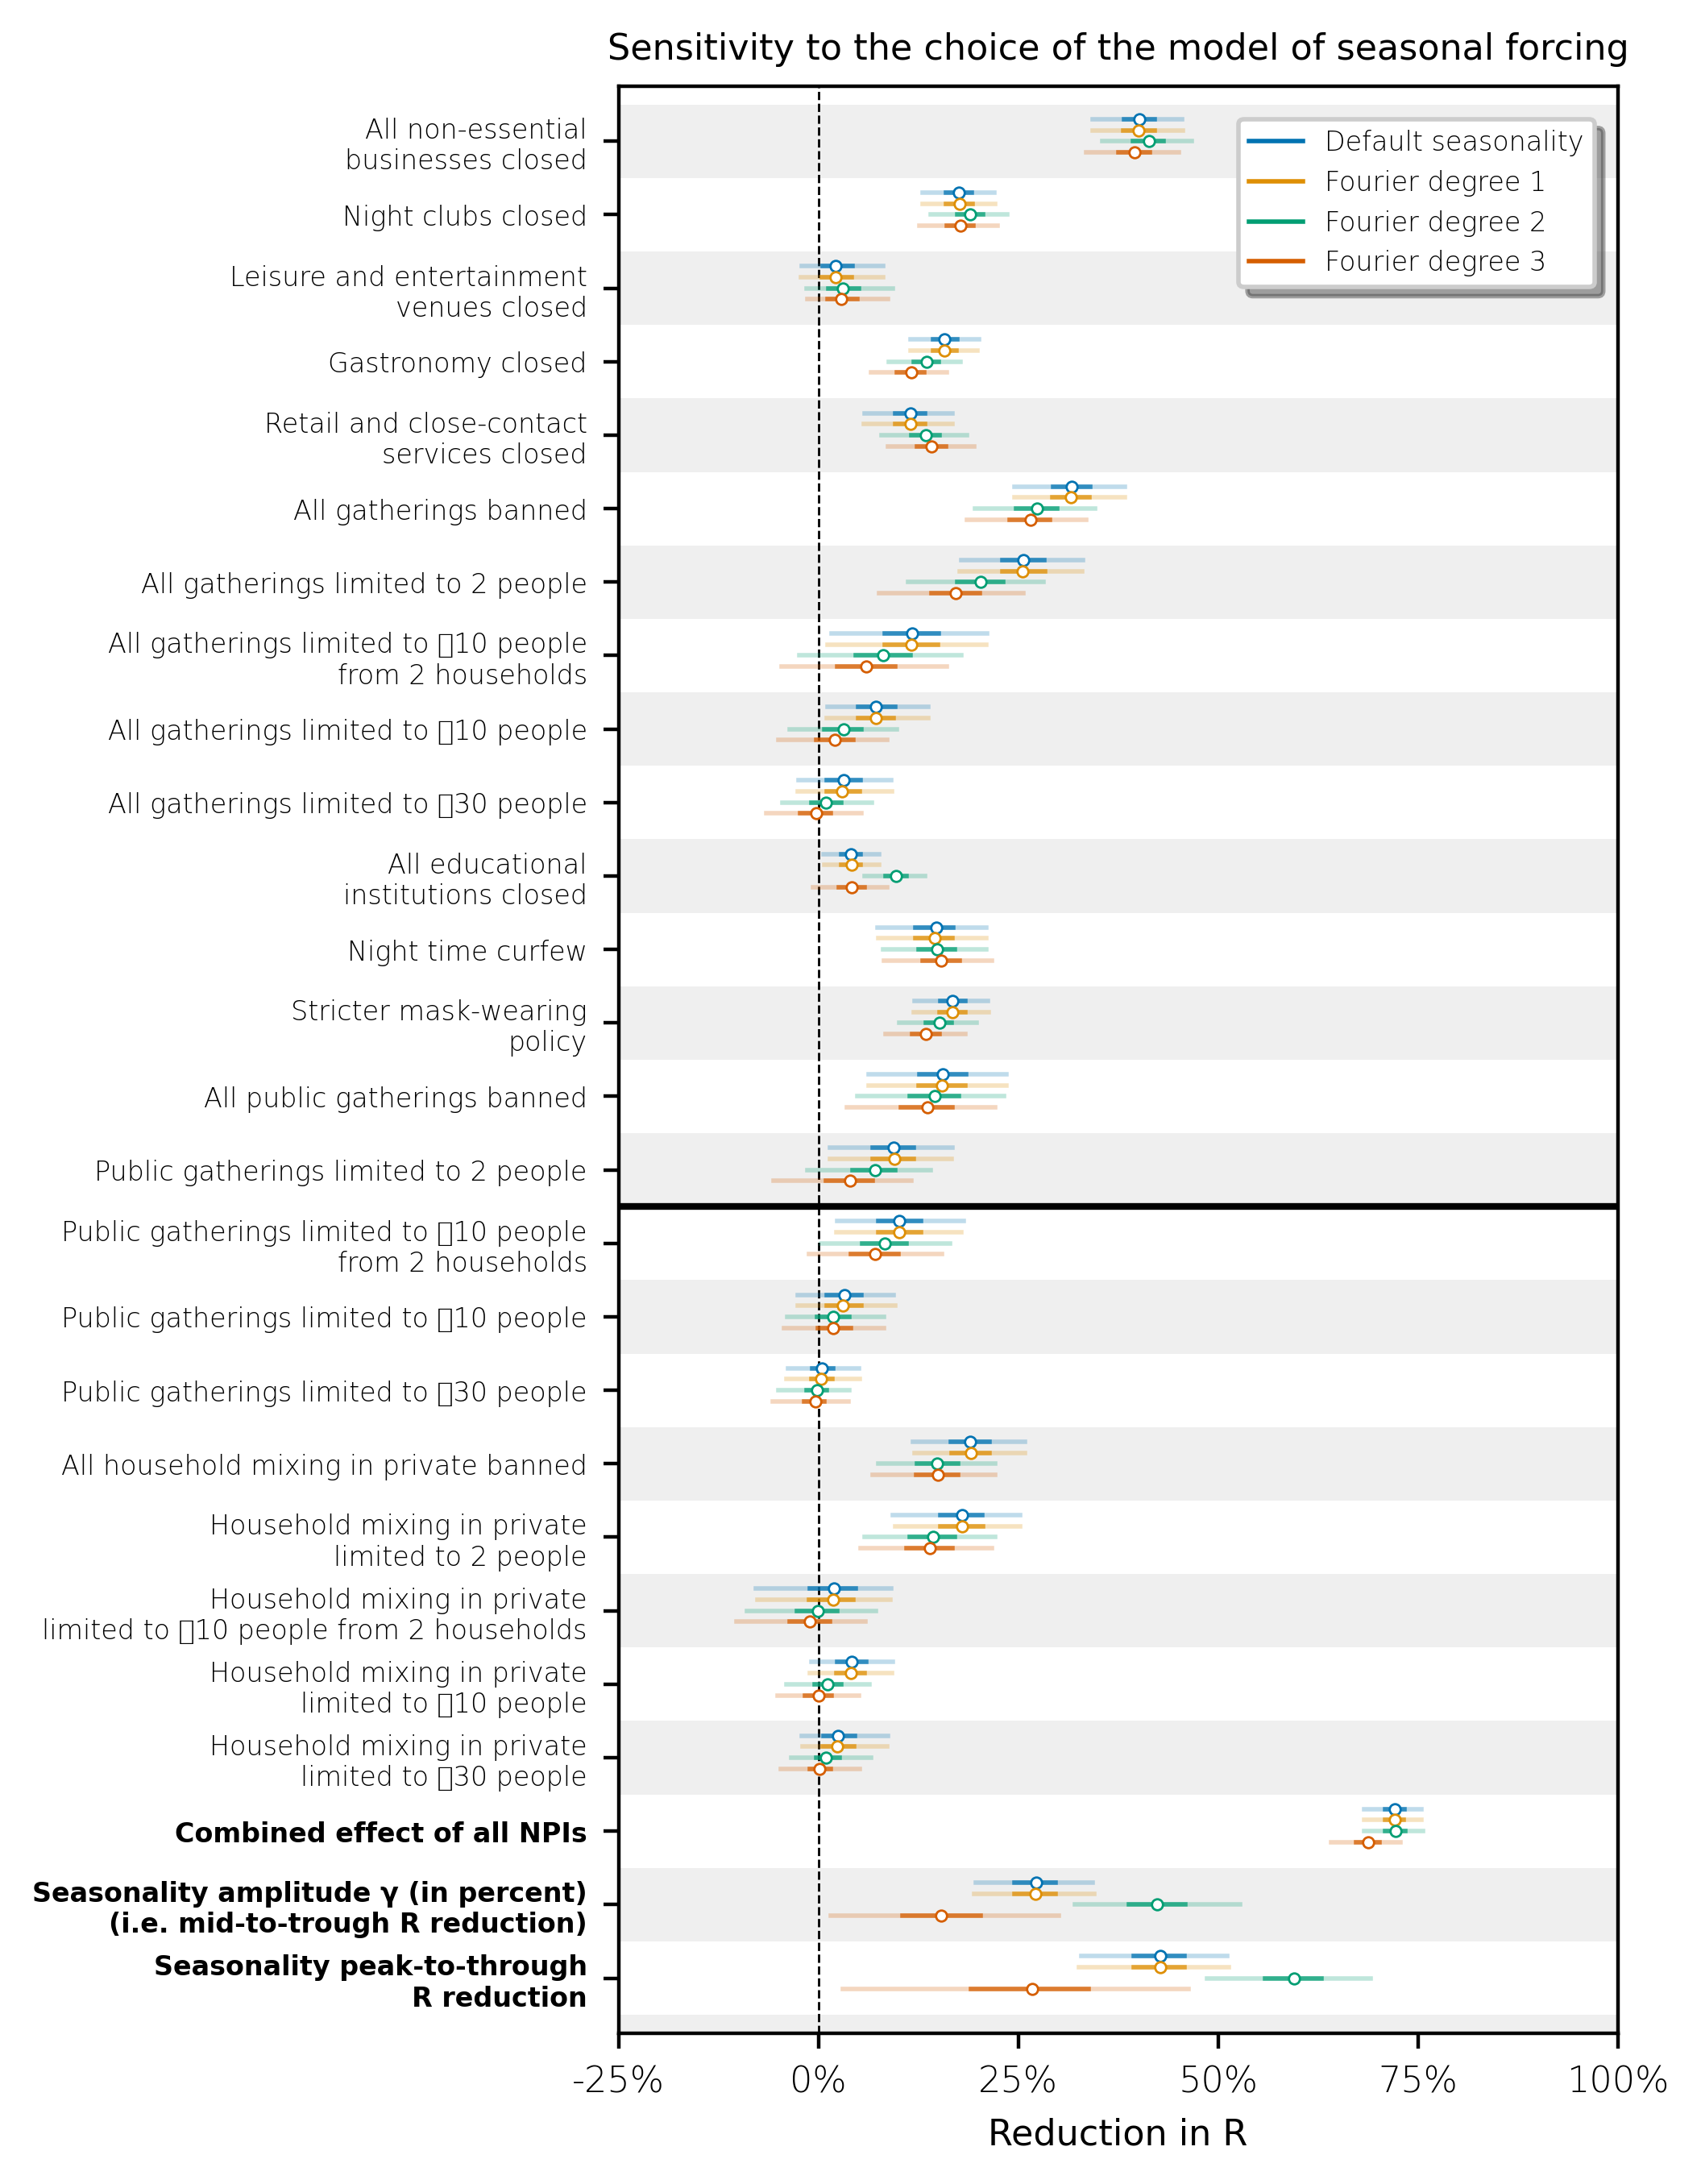

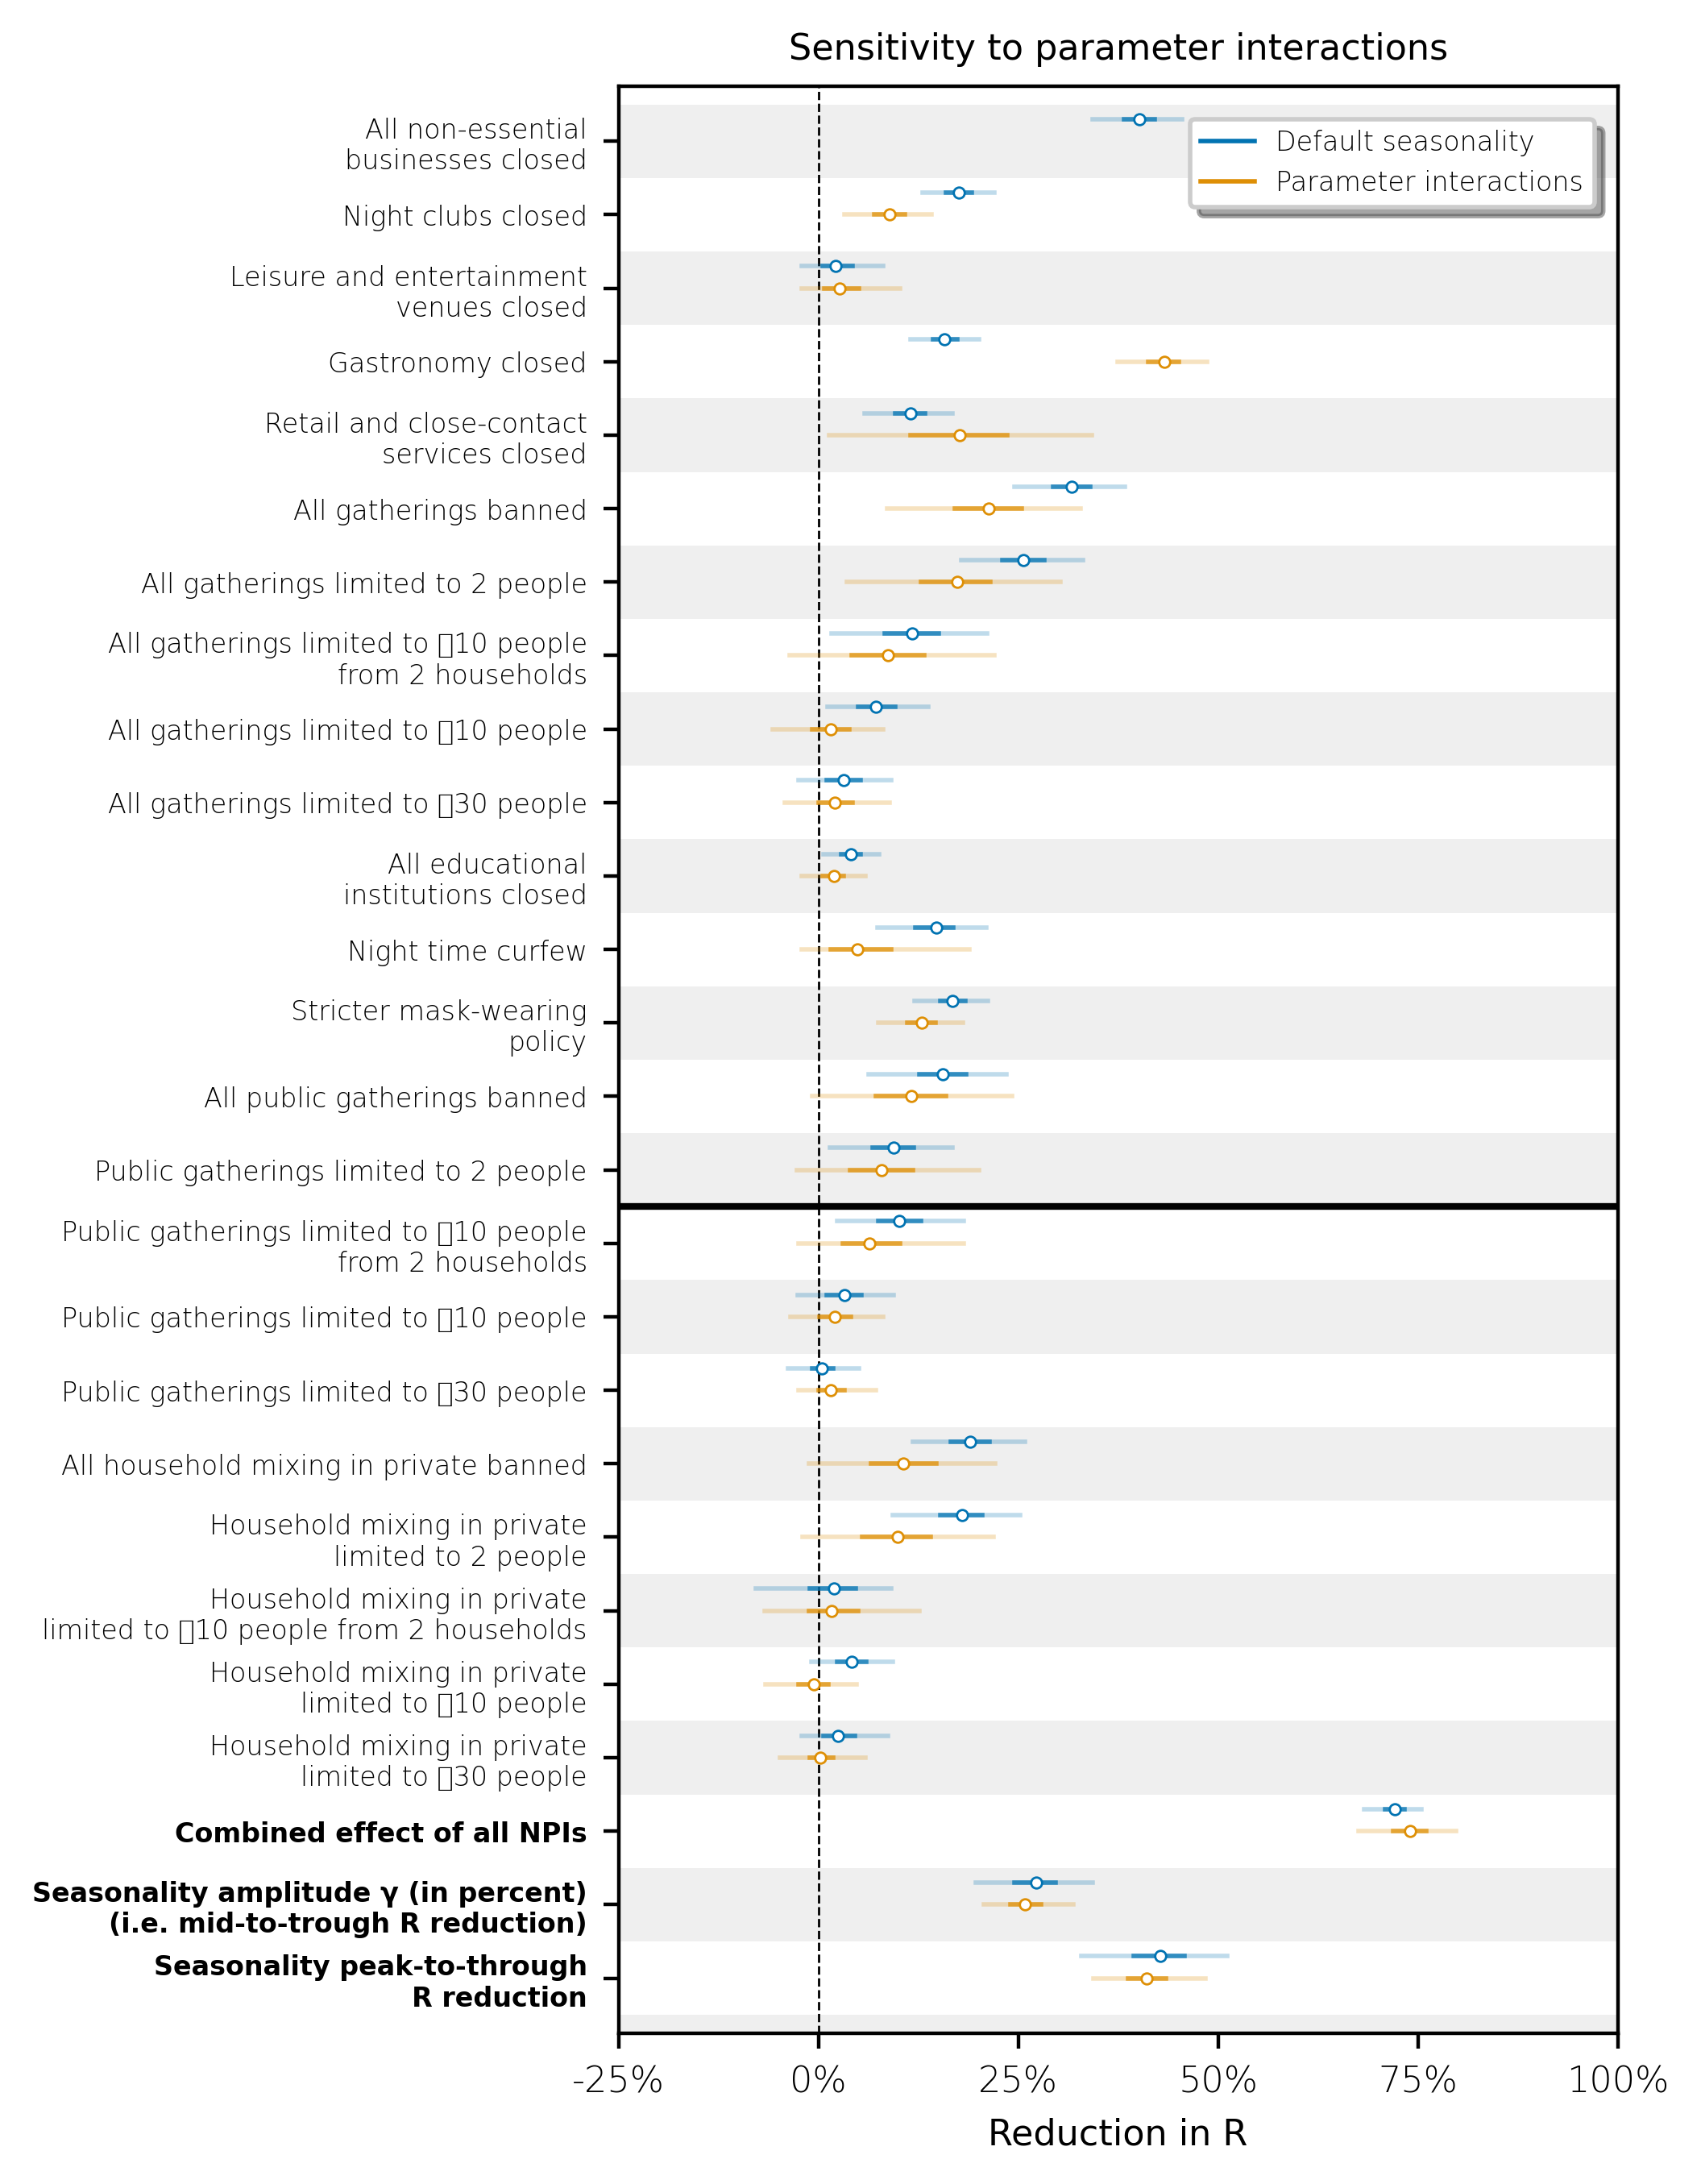

In [10]:
all_experiments = get_all_experiments(f'../../sensitivity_analysis/')
all_experiments = [e for e in all_experiments if e['DATA'].rstrip('TEW') == DATA.rstrip('TE')]

print(f"Filtered down to: {len(all_experiments)} for data {DATA}")

for MODEL in ["Brauner", "Sharma"]:
    experiments = [e for e in all_experiments if f"model{MODEL}" in e['model_config_name']]
    print(f"Filtered down to: {len(experiments)} for model {MODEL}")
    experiment_classes = make_all_experiment_classes(experiments, per_model_exp_info)
    print("Classes:", {c.exp_info["tag"]: len(c.experiments) for c in experiment_classes})
    for experiment_class in experiment_classes:
        plt.figure(figsize=(4, 8 if DATA=="Sharma" else 4), dpi=400)
        plot_experiment_class(experiment_class, grouped_npis, (-25, 100), default_alpha, default_names, prefix=f"model{MODEL}_data{DATA}_", newfig=False)

#experiments = all_experiments
experiments = [e for e in all_experiments if e['MODEL'] == DATA.rstrip('TE')]
experiment_classes = make_all_experiment_classes(experiments, cross_model_exp_info)
print("Classes:", {c.exp_info["tag"]: [e['FILENAME'] for e in c.experiments] for c in experiment_classes})
for experiment_class in experiment_classes:
    plt.figure(figsize=(4, 8 if DATA=="Sharma" else 4), dpi=400)
    if experiment_class.exp_info["tag"]=="NPI_effects_and_seasonality":
        print(len(experiment_class.experiments))
        print(experiment_class.experiments[0].keys())
        print(experiment_class.experiments[0]['data_path'])
        print(experiment_class.experiments[0]['MODEL'])
        print(experiment_class.experiments[0]['DATA'])
        plot_experiment_class(experiment_class, grouped_npis, (-25, 100), default_alpha, default_names, prefix=f"dataBraunerW_",
            newfig=False, width=2.5, legend=False, npi_fontsize=6.5,
            npi_priority={"Seasonality peak-to-through\n(Jan 1 to July 1) reduction": -2, "Combined effect of all NPIs": -1})
    else:    
        plot_experiment_class(experiment_class, grouped_npis, (-25, 100), default_alpha, default_names, prefix=f"data{DATA}_", newfig=False, width=1.5)
